# Computer Assignment 2

In this assignment we are using the dataset of the greenhouse gas. We have taken the first 15 rows of the data as the inout $X$ and the first element of the 16th row as the target $Y$.
The data contains 2921 samples which we are using the last 2920 samples.

For simplicity and avoid loading all small samples each time, we have stored the loaded files into "data_x.csv" and "data_y.csv".

First we import the required packages.
## Import packages

In [5]:
##imports from libraries
import pandas as pd
import numpy  as np
import time
import math
from   sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import resource
from   pathlib import Path
import random
from sklearn.utils import shuffle

## Load the dataset and store

In [25]:
## Preprocessing of data
# Load data here:
path = Path(Path().absolute())
DataPath=str(path.parent)+'/Data/'

#taking the last element of data as y
X_=np.ndarray((0,15*327))
Y_=np.ndarray((0,1))

#2921
for i in range(2920):
    #print(i)
    f_name=DataPath+'ghg_data/ghg.gid.site'+format(i+2,'04d')+'.dat'
    #print(f_name)
    data = pd.read_csv(f_name, sep=" ",header=None)
    #print(data.shape)
    X = data.iloc[0:15,:]
    Y = data.iloc[15:16,0:1]

    X = np.array(X).reshape(1,X.size)
    Y = np.array(Y).reshape(1,Y.size)
    X[np.isnan(X)] = 0
    Y[np.isnan(Y)] = 0
    
    X = X.astype(float)
    Y = Y.astype(float)
    
    X_=np.append(X_,X,axis=0)
    Y_=np.append(Y_,Y,axis=0)

X_=X_.T
Y_=Y_.T

print(X_.shape)
print(Y_.shape)

pd.DataFrame(X_).to_csv(DataPath+"data_x.csv",index=None)
pd.DataFrame(Y_).to_csv(DataPath+"data_y.csv",index=None)

(4905, 2920)
(1, 2920)


## Data load and split

In [27]:
#Load
#path = Path(Path().absolute())
#DataPath=str(path.parent)+'/Data/'
#X2 = pd.read_csv(DataPath+"data_x.csv",header=0)
#Y2 = pd.read_csv(DataPath+"data_y.csv",header=0)


# Split train and test data here: (X_train, Y_train, X_test, Y_test)
X_train=X_[:,0:X_.shape[1]//2]
Y_train=Y_[0,0:Y_.shape[1]//2]

X_test=X_[:,X_.shape[1]//2:]
Y_test=Y_[0,Y_.shape[1]//2:]

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(4905, 1460)
(4905, 1460)
(1460,)
(1460,)


## Functions
Here we implement two functions to compute the cost and gradient with respect to the $(x,y)$. We also defined a function to extract mini batches from the whole batch.

The gradient of f(w) can be derived as follows:
\begin{align}
\nabla f= \frac{1}{N}\sum_{i\in[N]}\frac{-y_i}{e^{y_i w^T x_i}+1}x_i + 2\lambda w
\end{align}

In [30]:
## Logistic ridge regression with different optimizers
# cost function and gradient calculation

def cost(x,y,w,lambda_ = 0.01):
    D, N = x.shape
    value = 0
    for i in range(N):
        Z = -1 * y[i] * np.matmul(w.T , (x[:,i]).reshape(D,1))
        value += np.log(1+np.exp(Z))
    norm_w = np.linalg.norm(w)
    c = lambda_ * norm_w ** 2
    return value/N + c 

def function_gradient(X, Y, w, lambda_):
    D,N=X.shape
    value = np.zeros((D,1))
    for i in range(N):       
        Z = Y[i] * np.matmul(w.T , (X[:,i]).reshape(D,1))
        Q=(-Y[i]/(1+np.exp(Z)))*(X[:,i]).reshape(D,1)        
        value += Q
        
    return value/N+2*lambda_*w

##Funtion to get mini batch sgd
def miniBatch(x,y,batchSize):
    D,N=x.shape
    X_mini=np.zeros((D,batchSize))
    Y_mini=np.zeros((batchSize,))
    indexArray = random.sample(range(N), batchSize)
    for i in range(batchSize):
        X_mini[:,i]=x[:,indexArray[i]]
        Y_mini[i,] =y[indexArray[i],]
    return X_mini,Y_mini

Next we define the solver function which takes the iterations to achieve the optimal solution. The solver includes Gradient descent (GD), Stochastic Gradient descent (SGD) with respect to mini batches, and Stochastic Gradient descent (SGD_Batch) which computes the gradient each time with respect to one sample and in each epoch it iterates on the whole batch, Stochastic Variance Reduced Gradient (SVRG), and Stochastic Average Gradient (SAG).


In [31]:
## Define solvers: GD, SGD, SVRG and SAG. 

# ---------------------- Complete the blank definitions: --------------------------------------

def solver(x,y, w, alpha, num_iters , lambda_ , epsilon , optimizer = "GD",mem=False):
    if (optimizer == "GD") :
        for i in range(num_iters):
            # update the parameter w for GD here:
            g = function_gradient(x, y, w, lambda_)                        

            cost1 = cost(X_test,Y_test,w,lambda_)
            cost2 = cost(X_test,Y_test,w-alpha*g,lambda_)
            if ((cost2-cost1)/cost1>0.5):
                break
            
            w = w-alpha*g
            
            if (i%10==0) and (mem):
                usage=resource.getrusage(resource.RUSAGE_SELF)
                print("mem for GD (mb):", (usage[2]*resource.getpagesize())/1000000.0)
            if (np.linalg.norm(g) <= epsilon):
                break
                
    elif (optimizer == "SGD"):
        #computes the SGD with respect to random mini-batches
        D,N=x.shape
        for i in range(num_iters):
            # get minibatch
            batchSize = 1
            X_mini, Y_mini = miniBatch(x,y,batchSize)
            # update the parameter w for SGD here:
            g = function_gradient(X_mini, Y_mini, w, lambda_)
            
            cost1 = cost(X_test,Y_test,w,lambda_)
            cost2 = cost(X_test,Y_test,w-alpha*g,lambda_)
            if ((cost2-cost1)/cost1>0.5):
                break

            w = w-alpha*g
            
            if (np.linalg.norm(g) <= epsilon):
                break

    elif (optimizer == "SGD_Batch"):
        #computes the SGD with respect to the whole batch
        for i in range(num_iters):
            D,N=x.shape
            #Random shuffling the batch            
            for i in shuffle(np.arange(N)):
                g_i= function_gradient(x[:,i:i+1], y[i:i+1], w, lambda_)
                w=w-alpha*g_i
            if (np.linalg.norm(g_i) <= epsilon):
                break                
                
                
    elif (optimizer == "SVRG"):
        T  = 100
        K  = math.floor(num_iters/T)
        N  = x.shape[1]
        wk_= w
        for k in range(K):
            ga_ = function_gradient(x, y, wk_, lambda_) #the average
            
            for t in range(T):
                index = np.random.randint(N, size=1)
                g1 = function_gradient(x[:,index], y[index,], w, lambda_)
                g2 = function_gradient(x[:,index], y[index,], wk_, lambda_)
                g  = g1-g2+ga_
                
                cost1 = cost(X_test,Y_test,w,lambda_)
                cost2 = cost(X_test,Y_test,w-alpha*g,lambda_)
                if ((cost2-cost1)/cost1>0.5):
                    break
                
                w  = w-alpha*g

                if (np.linalg.norm(g) <= epsilon):
                    break
            wk_ = w
            
        
    elif (optimizer == "SAG"):
        D,N = x.shape
        g_  = np.zeros((D,N))#initialize vector g_ in 0?

        for i in range(num_iters):
            index = np.random.randint(N, size=1)
            g_[:,index] = function_gradient(x[:,index], y[index,], w, lambda_)
            g = np.zeros((D,1))
            for j in range(N):               
                g = np.add(g,g_[:,j].reshape(D,1))
            g = g/N

            cost1 = cost(X_test,Y_test,w,lambda_)
            cost2 = cost(X_test,Y_test,w-alpha*g,lambda_)
            if ((cost2-cost1)/cost1>0.5):
                break
            
            w = w-alpha*g
            
            if (np.linalg.norm(g) <= epsilon):
                break
        
    return w



## Performance of optimizers

In [112]:
## Solving the optimization problem:
# Setting the values here:
num_iters = 200
alpha=0.05
lambda_=0.01
epsilon=0.00001


D,N = X_train.shape
w = np.random.rand(D,1)*0.04  # Initialization of w
print("Initial cost: ",cost(X_test,Y_test,w,lambda_))

#-------------------- GD Solver -----------------------
start=time.time()
gde = solver(X_train,Y_train,w,alpha,num_iters,lambda_,epsilon,optimizer="GD",mem=False)
end = time.time()
print("Weights of GD after convergence: \n",gde)
cost_value = cost(X_test,Y_test,gde,lambda_)
print("Cost of GD after convergence: ",cost_value)
print("Training time for GD: ", end-start , ' sconds')


#-------------------- SGD minibatch Solver -----------------------
start=time.time()
sgde = solver(X_train,Y_train,w,alpha,num_iters,lambda_,epsilon,optimizer="SGD",mem=False)
end = time.time()
print("\n\nWeights of SGD after convergence: \n",sgde)
cost_value = cost(X_test,Y_test,sgde,lambda_)
print("Cost of SGD after convergence: ",cost_value)
print("Training time for SGD: ", end-start , ' sconds')


#-------------------- SVRG Solver -----------------------
# complete here :
start=time.time()
sgde = solver(X_train,Y_train,w,alpha,num_iters,lambda_,epsilon,optimizer="SVRG",mem=False)
end = time.time()
print("\n\nWeights of SVRG after convergence: \n",sgde)
cost_value = cost(X_test,Y_test,sgde,lambda_)
print("Cost of SVRG after convergence: ",cost_value)
print("Training time for SVRG: ", end-start , ' sconds')

#-------------------- SAG Solver -----------------------
start=time.time()
sgde = solver(X_train,Y_train,w,alpha,num_iters,lambda_,epsilon,optimizer="SAG",mem=False) 
end = time.time()
print("\n\nWeights of SAG after convergence: \n",sgde)
cost_value = cost(X_test,Y_test,sgde,lambda_)
print("Cost of SAG after convergence: ",cost_value)
print("Training time for SAG: ", end-start , ' sconds')

Initial cost:  [[0.03171878]]


/home/sina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp


Weights of GD after convergence: 
 [[2.35048068e-02]
 [4.16764860e-05]
 [2.05396614e-02]
 ...
 [2.10463829e-02]
 [3.11771796e-02]
 [7.74414245e-03]]
Cost of GD after convergence:  [[0.02319306]]
Training time for GD:  14.524716138839722  sconds


Weights of SGD after convergence: 
 [[2.35048144e-02]
 [4.16840603e-05]
 [2.05391865e-02]
 ...
 [2.11852900e-02]
 [3.12974237e-02]
 [7.85622434e-03]]
Cost of SGD after convergence:  [[0.02328996]]
Training time for SGD:  0.02161574363708496  sconds


Weights of SVRG after convergence: 
 [[2.35048076e-02]
 [4.16773194e-05]
 [2.05396814e-02]
 ...
 [2.10583041e-02]
 [3.11927265e-02]
 [7.75960963e-03]]
Cost of SVRG after convergence:  [[0.02320513]]
Training time for SVRG:  0.1857316493988037  sconds


Weights of SAG after convergence: 
 [[2.83360767e-02]
 [5.02588471e-05]
 [2.47615528e-02]
 ...
 [2.56322754e-02]
 [3.79009190e-02]
 [9.62873919e-03]]
Cost of SAG after convergence:  [[0.03105121]]
Training time for SAG:  15.46412706375122  sconds


...... 0 .......
...... 1 .......


/home/sina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp


...... 2 .......
...... 3 .......
...... 4 .......
...... 5 .......
...... 6 .......
...... 7 .......
...... 8 .......
...... 9 .......
...... 10 .......
...... 11 .......
...... 12 .......
...... 13 .......
...... 14 .......
...... 15 .......
...... 16 .......
...... 17 .......
...... 18 .......
...... 19 .......
...... 20 .......
...... 21 .......
...... 22 .......
...... 23 .......
...... 24 .......
...... 25 .......
...... 26 .......
...... 27 .......
...... 28 .......
...... 29 .......
...... 30 .......
...... 31 .......
...... 32 .......
...... 33 .......
...... 34 .......
...... 35 .......
...... 36 .......
...... 37 .......
...... 38 .......
...... 39 .......
...... 40 .......
...... 41 .......
...... 42 .......
...... 43 .......
...... 44 .......
...... 45 .......
...... 46 .......
...... 47 .......
...... 48 .......
...... 49 .......


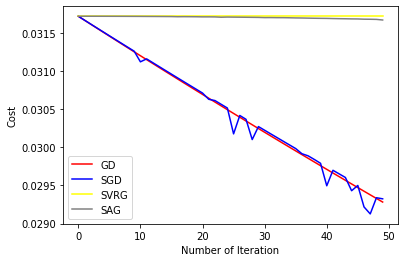

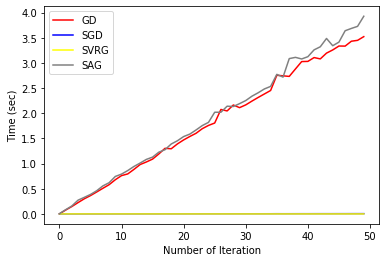

In [113]:
## Executing the iterations and plot the cost function here:

ti= np.zeros((50,4))
cost_= np.zeros((50,4))
for i in range(50):
    print("......",i,".......")
    #--------------GD-------------------
    start = time.time()
    gde = solver(X_train,Y_train,w,alpha,num_iters=i,lambda_=lambda_,epsilon=epsilon,optimizer="GD",mem=False)
    end = time.time()

    cost_[i,0] = cost(X_test,Y_test,gde,lambda_)

    ti[i,0] = end-start

    #---------------SGD------------------
    start = time.time()
    sgde = solver(X_train,Y_train,w,alpha,num_iters=i,lambda_=lambda_,epsilon=epsilon,optimizer="SGD",mem=False)
    end = time.time()

    cost_[i,1] = cost(X_test,Y_test,sgde,lambda_)

    ti[i,1] = end-start

    
    #---------------SVRG----------------
    start = time.time()
    sgde = solver(X_train,Y_train,w,alpha,num_iters=i,lambda_=lambda_,epsilon=epsilon,optimizer="SVRG",mem=False)
    end = time.time()

    cost_[i,2] = cost(X_test,Y_test,sgde,lambda_)

    ti[i,2] = end-start
    
    #---------------SAG------------------
    start = time.time()
    sgde = solver(X_train,Y_train,w,alpha,num_iters=i,lambda_=lambda_,epsilon=epsilon,optimizer="SAG",mem=False)
    end = time.time()

    cost_[i,3] = cost(X_test,Y_test,sgde,lambda_)

    ti[i,3] = end-start
    
    #------------------------------------
    
    ## Pl the results:
    

l0 = plt.plot(cost_[:,0],color="red")
l0 = plt.plot(cost_[:,1],color="blue")
l0 = plt.plot(cost_[:,2],color="yellow")
l0 = plt.plot(cost_[:,3],color="gray")



plt.xlabel("Number of Iteration")
plt.ylabel("Cost")
plt.legend(['GD', 'SGD', 'SVRG', 'SAG'])
plt.show()

l0 = plt.plot(ti[:,0],color="red")
l0 = plt.plot(ti[:,1],color="blue")
l0 = plt.plot(ti[:,2],color="yellow")
l0 = plt.plot(ti[:,3],color="gray")



plt.xlabel("Number of Iteration")
plt.ylabel("Time (sec)")
plt.legend(['GD', 'SGD', 'SVRG', 'SAG'])
plt.show()

In [ ]:
num_iters = 200
alpha=0.05
lambda_=0.01
epsilon=0.00001


D,N = X_train.shape
w = np.random.rand(D,1)*0.04  # Initialization of w
## Executing the iterations and plot the cost function here:
ti= np.zeros((21,4))
cost_= np.zeros((21,4))
cc=0
for i in 10*np.arange(21):
    print("......",i,".......")
    #--------------GD-------------------
    start = time.time()
    gde = solver(X_train,Y_train,w,alpha,num_iters=i,lambda_=lambda_,epsilon=epsilon,optimizer="GD",mem=False)
    end = time.time()

    cost_[cc,0] = cost(X_test,Y_test,gde,lambda_)

    ti[cc,0] = end-start

    #---------------SGD------------------
    start = time.time()
    sgde = solver(X_train,Y_train,w,alpha,num_iters=i,lambda_=lambda_,epsilon=epsilon,optimizer="SGD",mem=False)
    end = time.time()

    cost_[cc,1] = cost(X_test,Y_test,sgde,lambda_)

    ti[cc,1] = end-start

    
    #---------------SVRG----------------
    start = time.time()
    sgde = solver(X_train,Y_train,w,alpha,num_iters=i,lambda_=lambda_,epsilon=epsilon,optimizer="SVRG",mem=False)
    end = time.time()

    cost_[cc,2] = cost(X_test,Y_test,sgde,lambda_)

    ti[cc,2] = end-start
    
    #---------------SAG------------------
    start = time.time()
    sgde = solver(X_train,Y_train,w,alpha,num_iters=i,lambda_=lambda_,epsilon=epsilon,optimizer="SAG",mem=False)
    end = time.time()

    cost_[cc,3] = cost(X_test,Y_test,sgde,lambda_)

    ti[cc,3] = end-start
    
    #------------------------------------
    
    ## Pl the results:
    cc+=1

l0 = plt.plot(cost_[:,0],color="red")
l0 = plt.plot(cost_[:,1],color="blue")
l0 = plt.plot(cost_[:,2],color="yellow")
l0 = plt.plot(cost_[:,3],color="gray")



plt.xlabel("Number of Iteration")
plt.ylabel("Cost")
plt.legend(['GD', 'SGD', 'SVRG', 'SAG'])
plt.show()

l0 = plt.plot(ti[:,0],color="red")
l0 = plt.plot(ti[:,1],color="blue")
l0 = plt.plot(ti[:,2],color="yellow")
l0 = plt.plot(ti[:,3],color="gray")



plt.xlabel("Number of Iteration")
plt.ylabel("Time (sec)")
plt.legend(['GD', 'SGD', 'SVRG', 'SAG'])
plt.show()

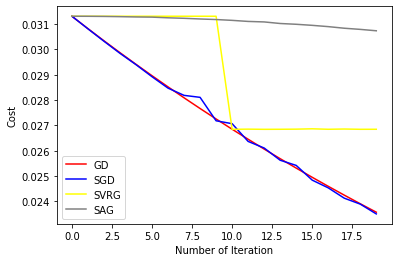

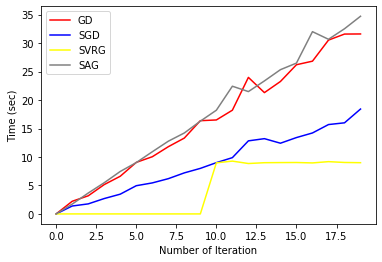

In [36]:
l0 = plt.plot(cost_[:,0],color="red")
l0 = plt.plot(cost_[:,1],color="blue")
l0 = plt.plot(cost_[:,2],color="yellow")
l0 = plt.plot(cost_[:,3],color="gray")



plt.xlabel("Number of Iteration")
plt.ylabel("Cost")
plt.legend(['GD', 'SGD', 'SVRG', 'SAG'])
plt.show()

plt.plot(ti[:,0],color="red")
plt.plot(ti[:,1],color="blue")
plt.plot(ti[:,2],color="yellow")
plt.plot(ti[:,3],color="gray")



plt.xlabel("Number of Iteration")
plt.ylabel("Time (sec)")
plt.legend(['GD', 'SGD', 'SVRG', 'SAG'])
plt.show()

## Tunning the hyper-paramter
In order to tune the hyper-parameters we search in a greedy manner

In [126]:
for alpha in [0.01,0.05,0.1]:
    for lambda_ in [0.01,0.05,0.1]:
        print('alpha=',alpha,'   lambda=',lambda_)
        D,N = X_train.shape
        w = np.random.rand(D,1)*0.04  # Initialization of w
        print("Initial cost: ",cost(X_test,Y_test,w,lambda_))

        #-------------------- GD Solver -----------------------
        start=time.time()
        gde = solver(X_train,Y_train,w,alpha,num_iters,lambda_,epsilon,optimizer="GD",mem=False)
        end = time.time()
        print("Cost of GD after convergence: ",cost_value)
        print("Training time for GD: ", end-start , ' sconds')


        #-------------------- SGD minibatch Solver -----------------------
        start=time.time()
        sgde = solver(X_train,Y_train,w,alpha,num_iters,lambda_,epsilon,optimizer="SGD",mem=False)
        end = time.time()
        cost_value = cost(X_test,Y_test,sgde,lambda_)
        print("Cost of SGD after convergence: ",cost_value)
        print("Training time for SGD: ", end-start , ' sconds')


        #-------------------- SVRG Solver -----------------------
        # complete here :
        start=time.time()
        sgde = solver(X_train,Y_train,w,alpha,num_iters,lambda_,epsilon,optimizer="SVRG",mem=False)
        end = time.time()
        cost_value = cost(X_test,Y_test,sgde,lambda_)
        print("Cost of SVRG after convergence: ",cost_value)
        print("Training time for SVRG: ", end-start , ' sconds')

        #-------------------- SAG Solver -----------------------
        start=time.time()
        sgde = solver(X_train,Y_train,w,alpha,num_iters,lambda_,epsilon,optimizer="SAG",mem=False) 
        end = time.time()
        cost_value = cost(X_test,Y_test,sgde,lambda_)
        print("Cost of SAG after convergence: ",cost_value)
        print("Training time for SAG: ", end-start , ' sconds') 
        print('------------')

alpha= 0.01    lambda= 0.01
Initial cost:  [[0.03166544]]


/home/sina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp


Cost of GD after convergence:  [[0.01327711]]
Training time for GD:  27.068992853164673  sconds
Cost of SGD after convergence:  [[0.02969993]]
Training time for SGD:  12.620570182800293  sconds
Cost of SVRG after convergence:  [[0.02967813]]
Training time for SVRG:  12.776097536087036  sconds
Cost of SAG after convergence:  [[0.03152765]]
Training time for SAG:  28.806747913360596  sconds
------------
alpha= 0.01    lambda= 0.05
Initial cost:  [[0.13917986]]
Cost of GD after convergence:  [[0.03152765]]
Training time for GD:  26.82203769683838  sconds
Cost of SGD after convergence:  [[0.09501452]]
Training time for SGD:  12.509345769882202  sconds
Cost of SVRG after convergence:  [[0.09524045]]
Training time for SVRG:  12.625456809997559  sconds
Cost of SAG after convergence:  [[0.13560396]]
Training time for SAG:  27.055964946746826  sconds
------------
alpha= 0.01    lambda= 0.1
Initial cost:  [[0.26886167]]
Cost of GD after convergence:  [[0.13560396]]
Training time for GD:  26.5899

/home/sina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':


Cost of SVRG after convergence:  [[0.01976506]]
Training time for SVRG:  11.167307138442993  sconds
Cost of SAG after convergence:  [[0.2078512]]
Training time for SAG:  27.36953043937683  sconds
------------
alpha= 0.1    lambda= 0.01
Initial cost:  [[0.0308786]]
Cost of GD after convergence:  [[0.2078512]]
Training time for GD:  26.52171492576599  sconds
Cost of SGD after convergence:  [[0.01753612]]
Training time for SGD:  12.459307670593262  sconds
Cost of SVRG after convergence:  [[0.01742049]]
Training time for SVRG:  12.64881706237793  sconds
Cost of SAG after convergence:  [[0.02959421]]
Training time for SAG:  27.069656133651733  sconds
------------
alpha= 0.1    lambda= 0.05
Initial cost:  [[0.13446081]]
Cost of GD after convergence:  [[0.02959421]]
Training time for GD:  18.181743144989014  sconds
Cost of SGD after convergence:  [[0.02180508]]
Training time for SGD:  6.891653299331665  sconds
Cost of SVRG after convergence:  [[0.01840421]]
Training time for SVRG:  8.11439561

## GD with 200 iteration
Note that in the solver we stop if the cost increases too much.

| alpha         | lambda        | Cost     |
| ------------- |:-------------:| --------:|
| 0.01          | 0.01          | **0.0132**   |
| 0.01          | 0.05          | 0.0315   |
| 0.01          | 0.1           | 0.1356   |
| 0.05          | 0.01          | 0.2548   |
| 0.05          | 0.05          | 0.0301   |
| 0.05          | 0.1           | 0.1118   |
| 0.1           | 0.01          | 0.2078   |
| 0.1           | 0.05          | 0.0295   |
| 0.1           | 0.1           | 0.1035   |


## SGD with 200 iteration
Note that in the solver we stop if the cost increases too much.

| alpha         | lambda        | Cost     |
| ------------- |:-------------:| --------:|
| 0.01          | 0.01          | 0.0296   |
| 0.01          | 0.05          | 0.0950   |
| 0.01          | 0.1           | 0.1244   |
| 0.05          | 0.01          | 0.0227   |
| 0.05          | 0.05          | 0.0254   |
| 0.05          | 0.1           | **0.0180**   |
| 0.1           | 0.01          | **0.0175**   |
| 0.1           | 0.05          | 0.0218   |
| 0.1           | 0.1           | 0.0188   |


## SVRG with 200 iteration
Note that in the solver we stop if the cost increases too much.

| alpha         | lambda        | Cost     |
| ------------- |:-------------:| --------:|
| 0.01          | 0.01          | 0.0296   |
| 0.01          | 0.05          | 0.0952   |
| 0.01          | 0.1           | 0.1242   |
| 0.05          | 0.01          | 0.0301   |
| 0.05          | 0.05          | 0.0250   |
| 0.05          | 0.1           | 0.0197   |
| 0.1           | 0.01          | **0.0174**   |
| 0.1           | 0.05          | **0.0184**   |
| 0.1           | 0.1           | 0.0200   |


## SAG with 200 iteration
Note that in the solver we stop if the cost increases too much.

| alpha         | lambda        | Cost     |
| ------------- |:-------------:| --------:|
| 0.01          | 0.01          | 0.0315   |
| 0.01          | 0.05          | 0.1356   |
| 0.01          | 0.1           | 0.2548   |
| 0.05          | 0.01          | **0.0226**   |
| 0.05          | 0.05          | 0.1189   |
| 0.05          | 0.1           | 0.2078   |
| 0.1           | 0.01          | 0.0295   |
| 0.1           | 0.05          | 0.1035   |
| 0.1           | 0.1           | 0.1513   |


## Comparison

From simluations it is inferred that the GD and SAG take more time in total than SGD and SVRG. The accuracy of GD was better in total and the best parameters are alpha=0.01 and lambda=0.01.
In terms of memory SAG requires more memory as we should update separately the gradient corresponding to each sample. In fact the SAG requires N meomry while the other requires only one vecotr to store.